In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

NUM_GENES = 45
NUM_ROUNDS = 30
NUM_GAMES = 50
NUM_GENERATIONS = 200
RESULTS_DIR = "simulation/results/results_withCats_SChMUSR_fear_chat_1"

def getGenes(results, numCopies):
    genes = results["genes"]
    genes = genes.str.split("_")
    genes = genes.apply(lambda x: x[1:])
    return genes

In [2]:
# make one dataframe with all the csv files for the result set and add a column for the generation
orderedGenes = ['visualTrait', 'homophily', 'alpha', 'otherishDebtLimits', 'coalitionTarget', 'fixedUsage', 'wModularity', 'wCentrality', 'wCollectiveStrength', 'wFamiliarity', 'wProsocial', 'initialDefense', 'minKeep', 'defenseUpdate', 'defensePropensity', 'fearDefense', 'safetyFirst', 'pillageFury', 'pillageDelay', 'pillagePriority', 'pillageMargin', 'pillageCompanionship', 'pillageFriends', 'vengeanceMultiplier', 'vengeanceMax', 'vengeancePriority', 'defendFriendMultiplier', 'defendFriendMax', 'defendFriendPriority', 'attackGoodGuys', 'limitingGive', 'groupAware', 'joinCoop', 'trustRate', 'distrustRate', 'startingTrust', 'wChatAgreement', 'wTrust', 'wAccusations', 'fearAggression', 'fearGrowth', 'fearSize', 'fearContagion', 'fearThreshold', 'fearPriority',]
gene_names = []
for i in range(3):
    for j in range(NUM_GENES):
        gene_names.append(orderedGenes[j] + "_" + str(i))

def makeDataFrame(folder, topNum=100, labels = ["genes", "count", "relativeFitness", "absoluteFitness"]):
    data = []
    for i in range(NUM_GENERATIONS):
        df = pd.read_csv(
            "{}/gen_{}.csv".format(folder, i),
            names=labels,
            sep=","
        )
 
        df["generation"] = i
        # # create new columns for each gene
        # genes = getGenes(df, 3)
        # for geneStringIdx in range(len(genes)):
        #     for geneIdx in range(len(genes[geneStringIdx])):
        #         column = gene_names[geneIdx]
        #         value = genes[geneStringIdx][geneIdx]
        #         df.at[geneStringIdx, column] = int(value)

        # only append the last topNum rows (The top topNum genes)
        data.append(df.tail(topNum))
    return pd.concat(data, ignore_index=True)

In [3]:
def getEndingMetrics(folder, eval, hCABEvaluation=False):
    abortedCount = 0
    failedToReadCount = 0
    genCat = []
    genHCAB = []
    gen = 199

    roundKeep = []  
    roundGive =[]
    roundSteal = []

    for game in range(NUM_GAMES):
        # print("Gen: ", gen, " Game: ", game)
        if eval:
            try:
                chat_json = pd.read_json("{}/gameInfos/gameInfo_{}.json".format(folder, game))
                if chat_json["infos"][0]["status"] == 'aborted':
                    abortedCount += 1   
                # print("Aborted: ", abortedCount)
                    continue
            except Exception as e:
                failedToReadCount += 1
                # print('Failed to read: ', "{}/gameInfos/gen_{}/gameInfo_{}_{}.json".format(folder, gen, gen, game))
                continue            
        else:
            try:
                chat_json = pd.read_json("{}/gameInfos/gen_{}/gameInfo_{}_{}.json".format(folder, gen, gen, game))
                if chat_json["infos"][0]["status"] == 'aborted':
                    abortedCount += 1   
                # print("Aborted: ", abortedCount)
                    continue
            except Exception as e:
                failedToReadCount += 1
                # print('Failed to read: ', "{}/gameInfos/gen_{}/gameInfo_{}_{}.json".format(folder, gen, gen, game))
                continue

        players = chat_json["infos"][0]["players"]
        cats = []
        hCABs = []
        for player in players:
            if (player["name"] == 'Cat'):
                cats.append(player["gameName"])
            elif "Gene " in player["name"]:
                hCABs.append(player["gameName"])

        for cat in cats:
            pop = chat_json["infos"][0]["popularities"][f'round_{NUM_ROUNDS}'][cat]
            genCat.append(pop)

        for hCAB in hCABs:
            pop = chat_json["infos"][0]["popularities"][f'round_{NUM_ROUNDS}'][hCAB]
            genHCAB.append(pop)

        transactions = chat_json["infos"][0]['transactions']    

        for round in range(NUM_ROUNDS):
            tokenAllocations = transactions['round_' + str(round)]
            if hCABEvaluation:
                agents = [agent for agent in tokenAllocations.keys() if agent not in cats]
            else:
                agents = [agent for agent in tokenAllocations.keys() if agent not in cats and agent not in hCABs]

            numTokens = len(tokenAllocations.keys()) * 2
            numPlayers = len(agents)

            keep = 0
            give = 0
            steal = 0
            for giver in agents:
                for reciever in tokenAllocations[giver].keys():
                    amount = tokenAllocations[giver][reciever]
                    if giver == reciever:
                        keep += amount
                    elif amount > 0:
                        give += amount
                    else:
                        steal += amount
            if (len(roundKeep) < round +1):
                roundKeep.append(keep)
                roundGive.append(give)
                roundSteal.append(steal)
            else:
                roundKeep[round] += keep
                roundGive[round] += give
                roundSteal[round] += steal

    if (NUM_GAMES*numTokens*numPlayers > 0 ):
        roundKeep = [x/(NUM_GAMES*numTokens*numPlayers) for x in roundKeep]
        roundGive = [x/(NUM_GAMES*numTokens*numPlayers) for x in roundGive]
        roundSteal = [-x/(NUM_GAMES*numTokens*numPlayers) for x in roundSteal]
            
    return genCat, genHCAB, roundKeep, roundGive, roundSteal


In [5]:
import os
import pandas as pd
from tqdm import tqdm
import warnings

conditions = ["SChMUSR_noFear_noChat", "SChMUSR_noFear_chat", "SChMUSR_fear_noChat", "SChMUSR_fear_chat",
              "SChMUSR_homogeneous_noFear_noChat", "SChMUSR_homogeneous_noFear_chat", "SChMUSR_homogeneous_fear_noChat", "SChMUSR_homogeneous_fear_chat",
              "SChMUSR_mixed_noFear_noChat", "SChMUSR_mixed_noFear_chat", "SChMUSR_mixed_fear_noChat", "SChMUSR_mixed_fear_chat","withCats_SChMUSR_noFear_noChat", "withCats_SChMUSR_noFear_chat", "withCats_SChMUSR_fear_noChat", "withCats_SChMUSR_fear_chat",
              "withCats_SChMUSR_homogeneous_noFear_noChat", "withCats_SChMUSR_homogeneous_noFear_chat", "withCats_SChMUSR_homogeneous_fear_noChat", "withCats_SChMUSR_homogeneous_fear_chat",
              "withCats_SChMUSR_mixed_noFear_noChat", "withCats_SChMUSR_mixed_noFear_chat", "withCats_SChMUSR_mixed_fear_noChat", "withCats_SChMUSR_mixed_fear_chat",              "withHCABs_SChMUSR_noFear_noChat", "withHCABs_SChMUSR_noFear_chat", "withHCABs_SChMUSR_fear_noChat", "withHCABs_SChMUSR_fear_chat",
              "withHCABs_SChMUSR_homogeneous_noFear_noChat", "withHCABs_SChMUSR_homogeneous_noFear_chat", "withHCABs_SChMUSR_homogeneous_fear_noChat", "withHCABs_SChMUSR_homogeneous_fear_chat",
              "withHCABs_SChMUSR_mixed_noFear_noChat", "withHCABs_SChMUSR_mixed_noFear_chat", "withHCABs_SChMUSR_mixed_fear_noChat", "withHCABs_SChMUSR_mixed_fear_chat", 
            "withHCABsAndCats_SChMUSR_noFear_noChat", "withHCABsAndCats_SChMUSR_noFear_chat", "withHCABsAndCats_SChMUSR_fear_noChat", "withHCABsAndCats_SChMUSR_fear_chat",
            "withHCABsAndCats_SChMUSR_homogeneous_noFear_noChat", "withHCABsAndCats_SChMUSR_homogeneous_noFear_chat", "withHCABsAndCats_SChMUSR_homogeneous_fear_noChat", "withHCABsAndCats_SChMUSR_homogeneous_fear_chat",
            "withHCABsAndCats_SChMUSR_mixed_noFear_noChat", "withHCABsAndCats_SChMUSR_mixed_noFear_chat", "withHCABsAndCats_SChMUSR_mixed_fear_noChat", "withHCABsAndCats_SChMUSR_mixed_fear_chat",
            "withCats_hCAB", "withCats_eCAB", "hCAB", "eCAB"
            ]

condition_names = ["No Fear, No Chat", "No Fear, Chat", "Fear, No Chat", "Fear, Chat",
                  "No Fear, No Chat (Homogeneous)", "No Fear, Chat (Homogeneous)", "Fear, No Chat (Homogeneous)", "Fear, Chat (Homogeneous)",
                  "No Fear, No Chat (Mixed)", "No Fear, Chat (Mixed)", "Fear, No Chat (Mixed)", "Fear, Chat (Mixed)",
                  "withCats No Fear, No Chat", "withCats No Fear, Chat", "withCats Fear, No Chat", "withCats Fear, Chat",
                  "withCats No Fear, No Chat (Homogeneous)", "withCats No Fear, Chat (Homogeneous)", "withCats Fear, No Chat (Homogeneous)", "withCats Fear, Chat (Homogeneous)",
                  "withCats No Fear, No Chat (Mixed)", "withCats No Fear, Chat (Mixed)", "withCats Fear, No Chat (Mixed)", "withCats Fear, Chat (Mixed)",
                  "withHCABs No Fear, No Chat", "withHCABs No Fear, Chat", "withHCABs Fear, No Chat", "withHCABs Fear, Chat",
                  "withHCABs No Fear, No Chat (Homogeneous)", "withHCABs No Fear, Chat (Homogeneous)", "withHCABs Fear, No Chat (Homogeneous)", "withHCABs Fear, Chat (Homogeneous)",
                  "withHCABs No Fear, No Chat (Mixed)", "withHCABs No Fear, Chat (Mixed)", "withHCABs Fear, No Chat (Mixed)", "withHCABs Fear, Chat (Mixed)",
                  "withHCABsAndCats No Fear, No Chat", "withHCABsAndCats No Fear, Chat", "withHCABsAndCats Fear, No Chat", "withHCABsAndCats Fear, Chat",
                  "withHCABsAndCats No Fear, No Chat (Homogeneous)", "withHCABsAndCats No Fear, Chat (Homogeneous)", "withHCABsAndCats Fear, No Chat (Homogeneous)", "withHCABsAndCats Fear, Chat (Homogeneous)",
                  "withHCABsAndCats No Fear, No Chat (Mixed)", "withHCABsAndCats No Fear, Chat (Mixed)", "withHCABsAndCats Fear, No Chat (Mixed)", "withHCABsAndCats Fear, Chat (Mixed)",
                  "withCats hCAB", "withCats eCAB", "hCAB", "eCAB"]

metrics = ["avg_fitness", "cat_avg_fitness", "cat_alive", "hCAB_avg_fitness", "count", "keep", "give", "steal"]


for parentFolder, save_file in [("../results", "evaluation_summary.csv"), 
                                ]:

    data = {f"{condition}_{metric}": [] for condition in conditions for metric in metrics}

    for folder in tqdm(os.listdir(parentFolder)):
        try:
            if folder.startswith("evaluation_"):
                if ".csv" in folder:
                    continue

                lastGen = pd.read_csv(f"{parentFolder}/{folder}/evaluation.csv", names=["genes", "count", "relativeFitness", "absoluteFitness"] + gene_names[:NUM_GENES])
                if "eCAB" in folder or "hCAB" in folder:
                    absoluteFitness = [np.nan]
                else:
                    absoluteFitness = lastGen["absoluteFitness"].values
                cabAgent = "CAB" in folder
                catPop, hCABPop, keep, give, steal = getEndingMetrics(parentFolder + '/' + folder, True, cabAgent)         
                num_cat_greater_than_10 = len([x for x in catPop if x > 5])

                for condition in conditions:
                    if folder.startswith(f"evaluation_{condition}"):
                        data[f"{condition}_avg_fitness"].extend(absoluteFitness)
                        data[f"{condition}_cat_avg_fitness"].extend(catPop)
                        data[f"{condition}_cat_alive"].extend([num_cat_greater_than_10])
                        data[f"{condition}_hCAB_avg_fitness"].extend(hCABPop)
                        data[f"{condition}_count"].append(1)
                        data[f"{condition}_keep"].extend(keep)
                        data[f"{condition}_give"].extend(give)
                        data[f"{condition}_steal"].extend(steal)
                        break
        except Exception as e:
            print("Failed to read: ", folder)
            print(e)
            continue

    warnings.filterwarnings("ignore", category=RuntimeWarning)
    csvData = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data.items()]))
    csvData.to_csv(f"{save_file}")


    results = pd.DataFrame({
        "Condition": condition_names,
        "SChMUSR Pop": [np.mean(data[f"{condition}_avg_fitness"]) for condition in conditions],
        "CAT Pop": [np.mean(data[f"{condition}_cat_avg_fitness"]) for condition in conditions],
        "CATs Mitigated": [(1- np.sum(data[f"{condition}_cat_alive"])/len(data[f"{condition}_cat_avg_fitness"]) )* 100 for condition in conditions],
        "CAB Pop": [np.mean(data[f"{condition}_hCAB_avg_fitness"]) for condition in conditions],
        "Num Runs": [len(data[f"{condition}_count"]) for condition in conditions],
        "Avg Keep": [np.mean(data[f"{condition}_keep"]) for condition in conditions],
        "Avg Give": [np.mean(data[f"{condition}_give"]) for condition in conditions],
        "Avg Steal": [np.mean(data[f"{condition}_steal"]) for condition in conditions]
    })

    print(results.to_string(index=False))


100%|██████████| 8/8 [00:00<00:00, 142179.80it/s]
/tmp/ipykernel_2328299/2699681011.py:76: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  csvData = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data.items()]))


                                      Condition  SChMUSR Pop  CAT Pop  CATs Mitigated  CAB Pop  Num Runs  Avg Keep  Avg Give  Avg Steal
                               No Fear, No Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                                  No Fear, Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                                  Fear, No Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                                     Fear, Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                 No Fear, No Chat (Homogeneous)          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                    No Fear, Chat (Homogeneous)          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                    Fear, No Chat (Homogeneous) 

100%|██████████| 9/9 [00:00<00:00, 256794.12it/s]
/tmp/ipykernel_2328299/2699681011.py:76: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  csvData = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data.items()]))


                                      Condition  SChMUSR Pop  CAT Pop  CATs Mitigated  CAB Pop  Num Runs  Avg Keep  Avg Give  Avg Steal
                               No Fear, No Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                                  No Fear, Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                                  Fear, No Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                                     Fear, Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                 No Fear, No Chat (Homogeneous)          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                    No Fear, Chat (Homogeneous)          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                    Fear, No Chat (Homogeneous) 

100%|██████████| 10/10 [00:00<00:00, 272357.40it/s]
/tmp/ipykernel_2328299/2699681011.py:76: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  csvData = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data.items()]))


                                      Condition  SChMUSR Pop  CAT Pop  CATs Mitigated  CAB Pop  Num Runs  Avg Keep  Avg Give  Avg Steal
                               No Fear, No Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                                  No Fear, Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                                  Fear, No Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                                     Fear, Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                 No Fear, No Chat (Homogeneous)          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                    No Fear, Chat (Homogeneous)          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                    Fear, No Chat (Homogeneous) 

100%|██████████| 11/11 [00:00<00:00, 286567.35it/s]
/tmp/ipykernel_2328299/2699681011.py:76: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  csvData = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data.items()]))


                                      Condition  SChMUSR Pop  CAT Pop  CATs Mitigated  CAB Pop  Num Runs  Avg Keep  Avg Give  Avg Steal
                               No Fear, No Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                                  No Fear, Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                                  Fear, No Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                                     Fear, Chat          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                 No Fear, No Chat (Homogeneous)          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                    No Fear, Chat (Homogeneous)          NaN      NaN             NaN      NaN         0       NaN       NaN        NaN
                    Fear, No Chat (Homogeneous) 

In [ ]:
colors = {
    "mixed": (0.85, 0.596, 0.619),  
    "homogeneous": (0.619, 0.85, 0.67),  
    "random": (0.619, 0.75, 0.85),  
    "withCats_mixed": (0.85, 0.596, 0.619),  
    "withCats_homogeneous": (0.619, 0.85, 0.67),  
    "withCats_random": (0.619, 0.75, 0.85),  
    "withHCABs_mixed": (0.85, 0.596, 0.619),  
    "withHCABs_homogeneous": (0.619, 0.85, 0.67),  
    "withHCABs_random": (0.619, 0.75, 0.85)  
}

def getColor(title):
    if "withCats" in title:
        if "mixed" in title:
            return "withCats_mixed", (colors["withCats_mixed"])
        elif "homogeneous" in title:
            return "withCats_homogeneous", (colors["withCats_homogeneous"])
        else:
            return "withCats_random", (colors["withCats_random"])
    elif "withHCABs" in title:  
        if "mixed" in title:
            return "withHCABs_mixed", (colors["withHCABs_mixed"])
        elif "homogeneous" in title:
            return "withHCABs_homogeneous", (colors["withHCABs_homogeneous"])
        else:
            return "withHCABs_random", (colors["withHCABs_random"])
    else:
        if "mixed" in title:
            return "mixed", (colors["mixed"])
        elif "homogeneous" in title:
            return "homogeneous", (colors["homogeneous"])
        else:
            return "random", (colors["random"])
        
def getPattern(title):
    if "noFear_noChat" in title:
        return "///"
    elif "noFear_chat" in title:
        return "\\\\\\"
    elif "fear_noChat" in title:
        return "xxx"
    elif "fear_chat" in title:
        return "ooo"
    else:
        return ""

def clean_label(title):
    title = title.replace(" (Homogeneous)", "")
    title = title.replace(" (Mixed)", "")
    title = title.replace("SChMUSR_", "")

    return title

                                      Condition  SChMUSR Pop   CAT Pop  CATs Mitigated   hCAB Pop  Num Runs  Avg Keep  Avg Give  Avg Steal
                               No Fear, No Chat   122.813465       NaN             NaN        NaN        20  0.622110  0.358802   0.019088
                                  No Fear, Chat   119.056364       NaN             NaN        NaN        11  0.664628  0.309435   0.018663
                                  Fear, No Chat   130.501762       NaN             NaN        NaN        18  0.579964  0.398291   0.021744
                                     Fear, Chat   143.178693       NaN             NaN        NaN        10  0.558620  0.410717   0.030663
                 No Fear, No Chat (Homogeneous)   282.939367       NaN             NaN        NaN        14  0.118678  0.861804   0.019518
                    No Fear, Chat (Homogeneous)   265.116217       NaN             NaN        NaN        13  0.142575  0.788504   0.024306
                    Fear, N

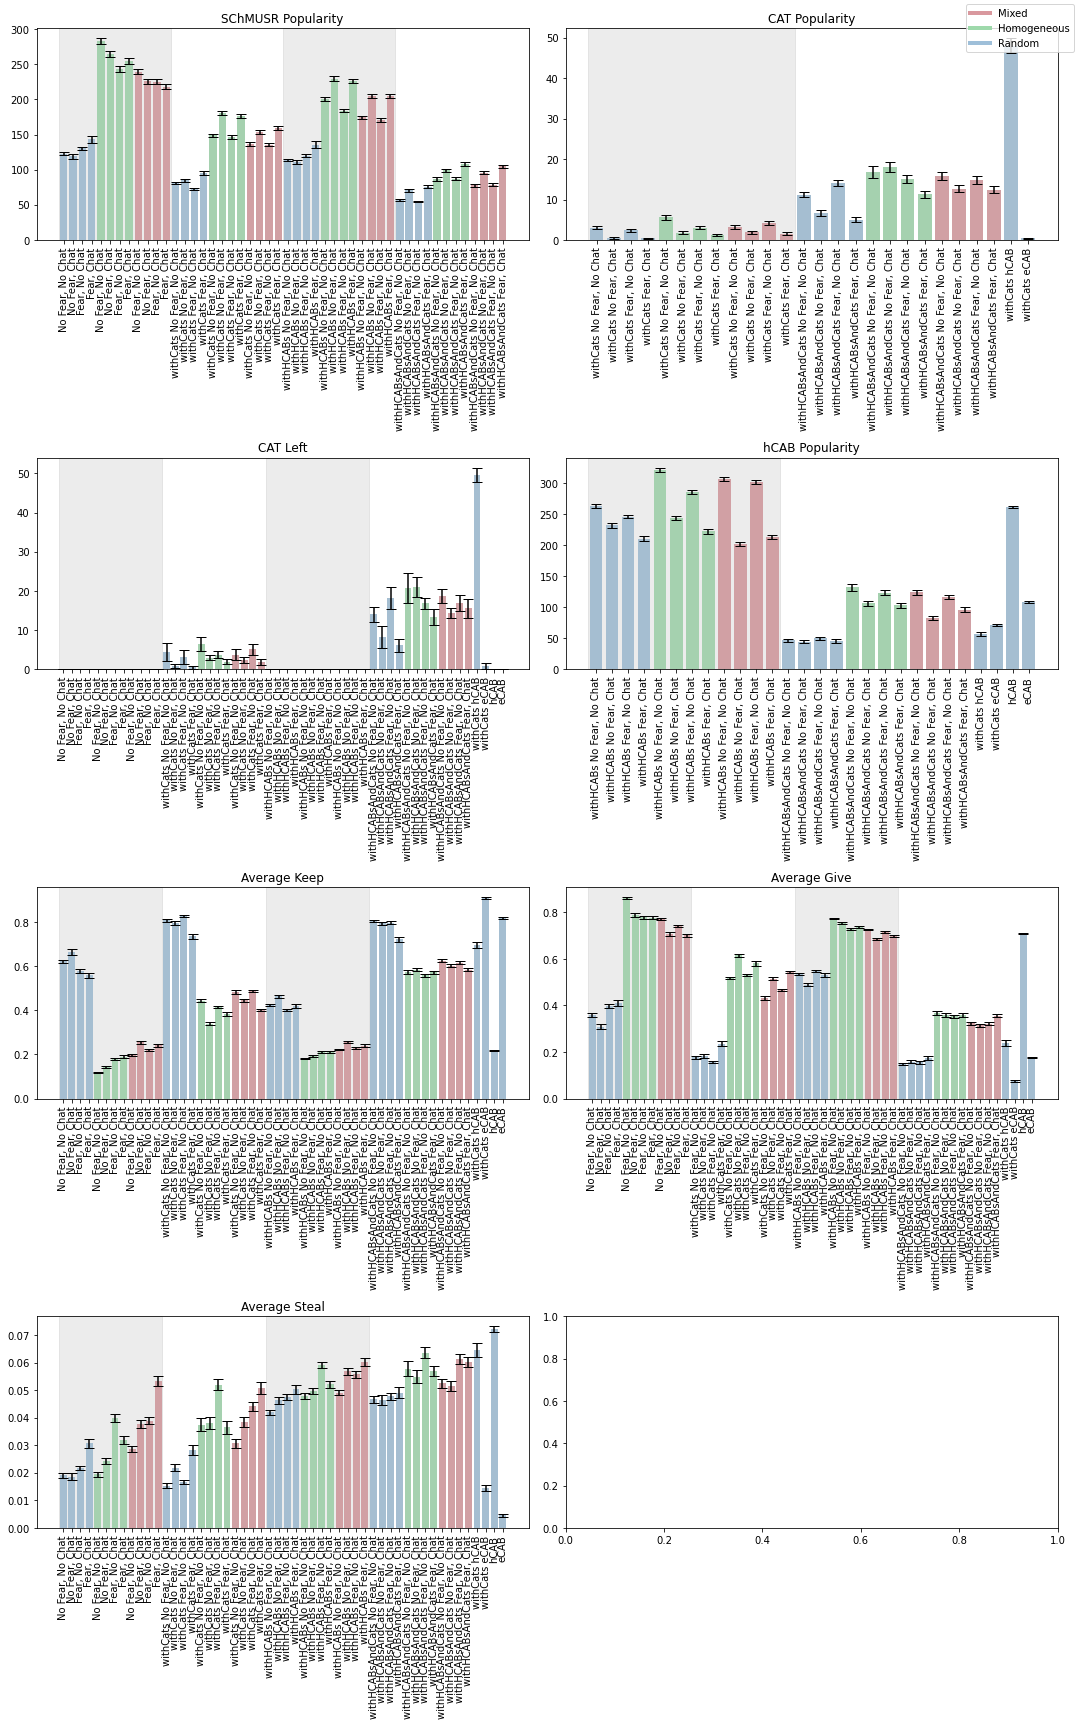

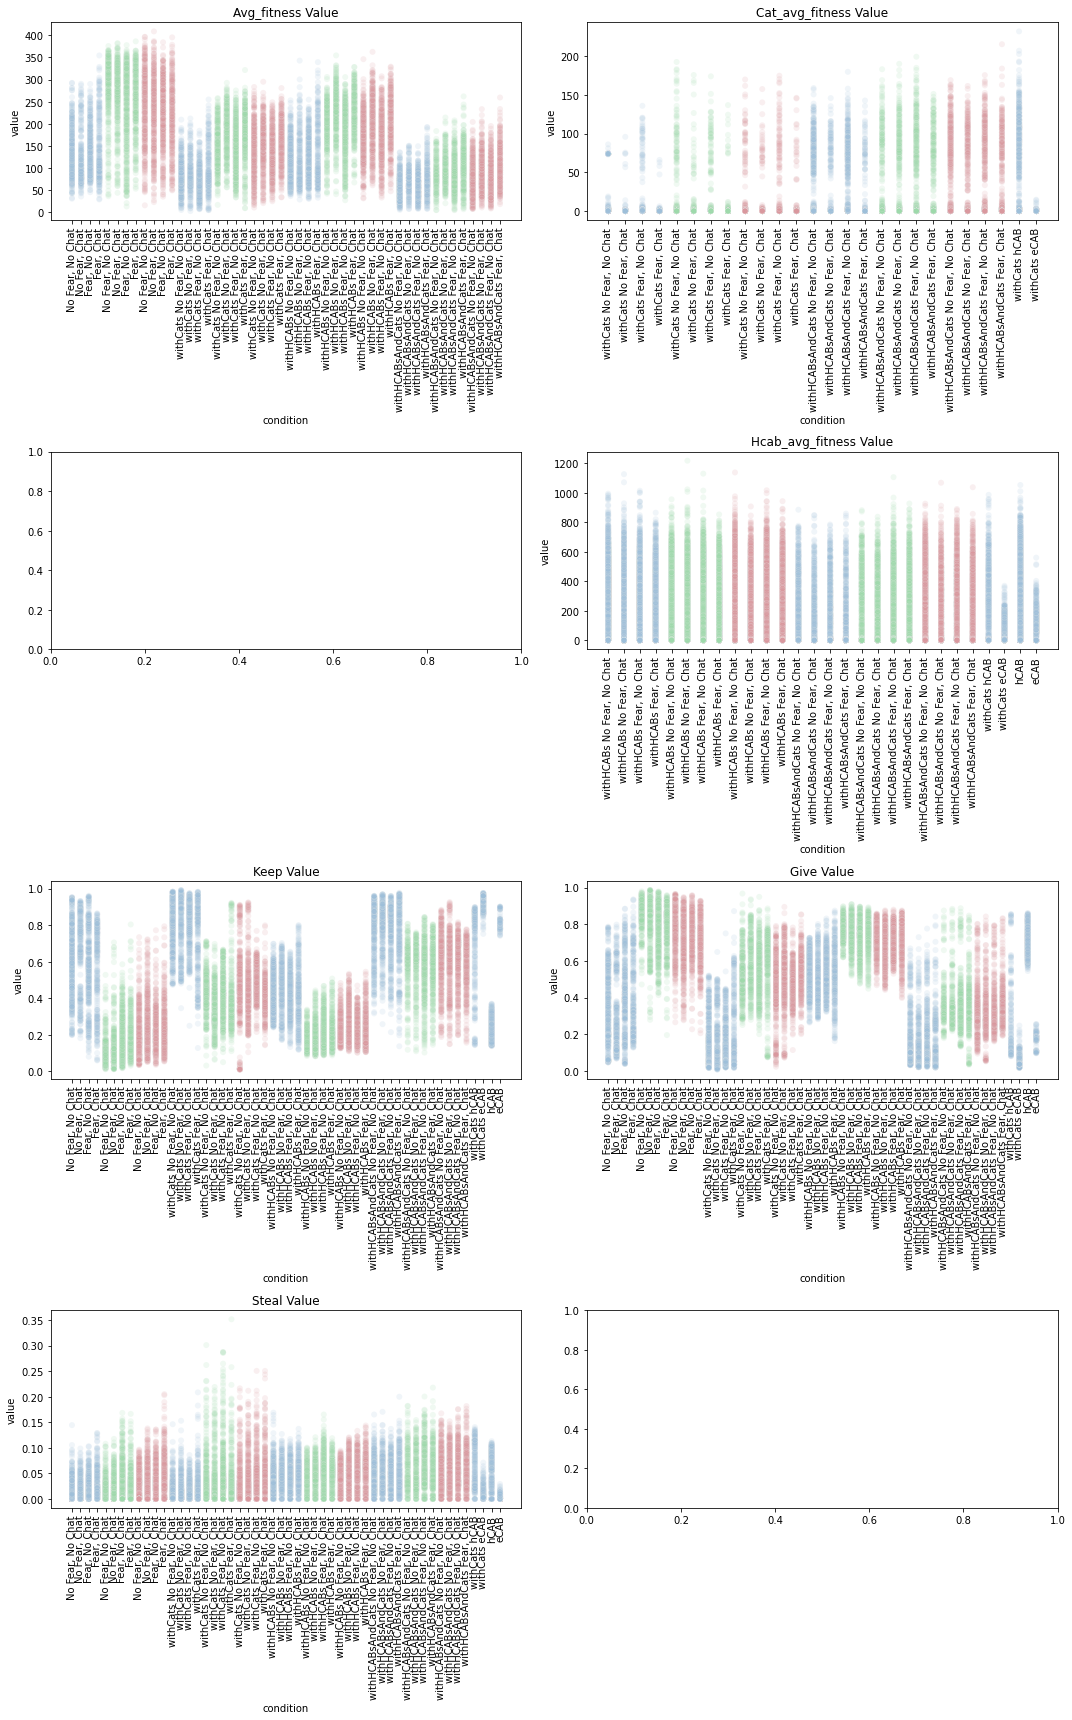

In [ ]:
import seaborn as sns

csvData1 = pd.read_csv("evaluation_summary_1.csv")
csvData2 = pd.read_csv("evaluation_summary_2.csv")
csvData3 = pd.read_csv("evaluation_summary_3.csv")
4 = pd.read_csv("evaluation_summary_4.csv")

combined_data = pd.concat([csvData2, csvData3, csvData1, 4], ignore_index=True)

# Show table

results = pd.DataFrame({
    "Condition": condition_names,
    "SChMUSR Pop": [np.mean(combined_data[f"{condition}_avg_fitness"]) for condition in conditions],
    "CAT Pop": [np.mean(combined_data[f"{condition}_cat_avg_fitness"]) for condition in conditions],
    "CATs Mitigated": [(1- np.sum(combined_data[f"{condition}_cat_alive"])/len(combined_data[f"{condition}_cat_avg_fitness"].dropna()) )* 100 for condition in conditions],
    "hCAB Pop": [np.mean(combined_data[f"{condition}_hCAB_avg_fitness"]) for condition in conditions],
    "Num Runs": [len(combined_data[f"{condition}_count"].dropna()) for condition in conditions],
    "Avg Keep": [np.mean(combined_data[f"{condition}_keep"]) for condition in conditions],
    "Avg Give": [np.mean(combined_data[f"{condition}_give"]) for condition in conditions],
    "Avg Steal": [np.mean(combined_data[f"{condition}_steal"]) for condition in conditions]
})

print(results.to_string(index=False))
results.to_csv("eval_all_summary.csv")
# Show graphs with error bars
plt.rcParams.update({'font.size': 10})  # Adjust the value as needed as needed
fig, axes = plt.subplots(4, 2, figsize=(15, 18+6))

titles = ["SChMUSR Popularity", "CAT Popularity", "CAT Left", "hCAB Popularity", "Average Keep", "Average Give", "Average Steal"]
metrics = ["avg_fitness", "cat_avg_fitness", "cat_alive", "hCAB_avg_fitness", "keep", "give", "steal"]

for i, metric in enumerate(titles):
    ax = axes[i // 2, i % 2]
    condition_means = []
    condition_lower_err = []
    condition_upper_err = []
    valid_conditions = []
    color_list = []
    pattern_list = []

    for condition, condition_name in zip(conditions, condition_names):
        if not combined_data[f"{condition}_{metrics[i]}"].dropna().empty:
            valid_conditions.append(condition_name)
            condition_data = combined_data[f"{condition}_{metrics[i]}"].dropna()
            if (metrics[i] == "cat_alive"):
                condition_means.append(np.sum(condition_data) / len(condition_data))
            else:
                condition_means.append(np.mean(condition_data))
            stderr = np.std(condition_data) / np.sqrt(len(condition_data))
            condition_lower_err.append(stderr)
            condition_upper_err.append(stderr)

            _, color = getColor(condition)
            color_list.append(color)

            pattern = getPattern(condition)
            pattern_list.append(pattern)

    if len(valid_conditions) >= 12:
        ax.axvspan(-0.5, 11.5, color='grey', alpha=0.15)

    if len(valid_conditions) >= 36:
        ax.axvspan(23.5, 35.5, color='grey', alpha=0.15)

    bars = sns.barplot(x=valid_conditions, y=condition_means, ax=ax, palette=color_list, capsize=.2)
    ax.errorbar(x=range(len(valid_conditions)), y=condition_means, yerr=(condition_lower_err, condition_upper_err), fmt='none', c='black', capsize=5)
    ax.set_title(titles[i])

    x_labels = [clean_label(condition) for condition in valid_conditions]
    ax.set_xticklabels(x_labels, rotation=90)

# Add legend
handles = [
    plt.Line2D([0], [0], color=colors["mixed"], lw=4, label='Mixed'),
    plt.Line2D([0], [0], color=colors["homogeneous"], lw=4, label='Homogeneous'),
    plt.Line2D([0], [0], color=colors["random"], lw=4, label='Random')
]
fig.legend(handles=handles, loc='upper right')

plt.tight_layout()
plt.show()


# plot each value in the combined data on a scatter plot. Make each condition a different color
fig, axes = plt.subplots(4, 2, figsize=(15, 18+6))

for i, metric in enumerate(metrics):
    if metric == "cat_alive":
        continue
    data = pd.DataFrame(columns=["condition", "value", "color"])
    for condition, condition_name in zip(conditions, condition_names):
        if not combined_data[f"{condition}_{metric}"].dropna().empty:
            color_name, _ = getColor(condition)
            data = pd.concat([data, pd.DataFrame({"condition": condition_name, "color": color_name, "value": combined_data[f"{condition}_{metric}"].dropna()})])
    ax = axes[i//2, i%2]
    sns.scatterplot(data=data, x="condition", y="value", hue="color", palette=colors, alpha=.15, legend=False, ax=ax)
    ax.set_xticks(range(len(data["condition"].unique())))  
    ax.set_xticklabels([clean_label(label) for label in data["condition"].unique()], rotation=90) 
    ax.set_title(f'{metric.capitalize()} Value')

plt.tight_layout()
plt.show()

In [64]:
colors = {
    "noFear_noChat": (0.85, 0.596, 0.619),
    "noFear_chat": (1.0, 0.9, 0.6),
    "fear_noChat": (0.619, 0.85, 0.67),
    "fear_chat": (0.619, 0.75, 0.85)
}

def getColor(title):
    if "noFear_noChat" in title:
        return colors["noFear_noChat"]
    elif "noFear_chat" in title:
        return colors["noFear_chat"]
    elif "fear_noChat" in title:
        return colors["fear_noChat"]
    else:
        return colors["fear_chat"]
    
def getConditionType(title):
    if "mixed" in title:
        return "Mixed"
    elif "homogeneous" in title:
        return "Homogeneous"
    else:
        return "Random"

# Generates SChMUSR popularity for CAT play only

                     Condition  SChMUSR Pop  CAT Pop  hCAB Pop  Num Runs  Avg Keep  Avg Give  Avg Steal
              No Fear, No Chat    81.493189 3.054517       NaN        18  0.807445  0.177154   0.015401
                 No Fear, Chat    84.997483 0.520206       NaN        11  0.796405  0.181706   0.021889
                 Fear, No Chat    72.626383 2.410597       NaN        18  0.826733  0.156555   0.016712
                    Fear, Chat    95.601957 0.401761       NaN        10  0.736176  0.235599   0.028225
No Fear, No Chat (Homogeneous)   149.039660 5.575406       NaN        14  0.444637  0.517816   0.037547
   No Fear, Chat (Homogeneous)   180.886405 1.857904       NaN        13  0.340272  0.615530   0.038045
   Fear, No Chat (Homogeneous)   146.514602 3.032188       NaN        19  0.417100  0.530890   0.052009
      Fear, Chat (Homogeneous)   176.182066 1.165418       NaN        12  0.382456  0.580987   0.036557
      No Fear, No Chat (Mixed)   136.305135 3.243952       NaN  

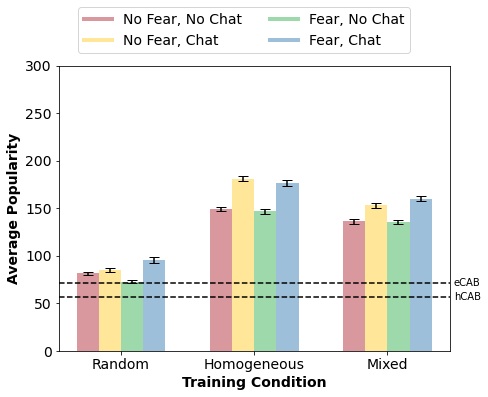

In [ ]:
import seaborn as sns

csvData1 = pd.read_csv("evaluation_summary_1.csv")
csvData2 = pd.read_csv("evaluation_summary_2.csv")
csvData3 = pd.read_csv("evaluation_summary_3.csv")
csvData4 = pd.read_csv("evaluation_summary_4.csv")


combined_data = pd.concat([csvData2, csvData3, csvData1, csvData4], ignore_index=True)

conditions = ["withCats_SChMUSR_noFear_noChat", "withCats_SChMUSR_noFear_chat", "withCats_SChMUSR_fear_noChat", "withCats_SChMUSR_fear_chat",
              "withCats_SChMUSR_homogeneous_noFear_noChat", "withCats_SChMUSR_homogeneous_noFear_chat", "withCats_SChMUSR_homogeneous_fear_noChat", "withCats_SChMUSR_homogeneous_fear_chat",
              "withCats_SChMUSR_mixed_noFear_noChat", "withCats_SChMUSR_mixed_noFear_chat", "withCats_SChMUSR_mixed_fear_noChat", "withCats_SChMUSR_mixed_fear_chat"             
            ]

condition_names = ["No Fear, No Chat", "No Fear, Chat", "Fear, No Chat", "Fear, Chat",
                  "No Fear, No Chat (Homogeneous)", "No Fear, Chat (Homogeneous)", "Fear, No Chat (Homogeneous)", "Fear, Chat (Homogeneous)",
                  "No Fear, No Chat (Mixed)", "No Fear, Chat (Mixed)", "Fear, No Chat (Mixed)", "Fear, Chat (Mixed)"
                  ]

results = pd.DataFrame({
    "Condition": condition_names,
    "SChMUSR Pop": [np.mean(combined_data[f"{condition}_avg_fitness"]) for condition in conditions],
    "CAT Pop": [np.mean(combined_data[f"{condition}_cat_avg_fitness"]) for condition in conditions],
    "hCAB Pop": [np.mean(combined_data[f"{condition}_hCAB_avg_fitness"]) for condition in conditions],
    "Num Runs": [len(combined_data[f"{condition}_count"].dropna()) for condition in conditions],
    "Avg Keep": [np.mean(combined_data[f"{condition}_keep"]) for condition in conditions],
    "Avg Give": [np.mean(combined_data[f"{condition}_give"]) for condition in conditions],
    "Avg Steal": [np.mean(combined_data[f"{condition}_steal"]) for condition in conditions]
})

print(results.to_string(index=False))

titles = ["SChMUSR Popularity"]
metrics = ["avg_fitness"]

plt.rcParams.update({'font.size': 14})  # Adjust the value as needed as needed
fig, ax = plt.subplots(figsize=(7, 5), layout='tight')  # Increased the figure width

labels = ["Random", "Homogeneous", "Mixed"]
x_positions = []
x = 0
width = 0.5
multiplier = 0

for i, metric in enumerate(titles):
    condition_lower_err = []
    condition_upper_err = []
    color_list = []
    condition_type = "Random"

    for condition, condition_name in zip(conditions, condition_names):
        if not combined_data[f"{condition}_{metrics[i]}"].dropna().empty:
            condition_data = combined_data[f"{condition}_{metrics[i]}"].dropna()
            stderr = np.std(condition_data) / np.sqrt(len(condition_data))
            condition_lower_err.append(stderr)
            condition_upper_err.append(stderr)

            offset = width * multiplier

            if condition_type != getConditionType(condition):
                x += 1
                condition_type = getConditionType(condition)

            if condition == "withCats_SChMUSR_fear_noChat" or condition == "withCats_SChMUSR_homogeneous_fear_noChat" or condition == "withCats_SChMUSR_mixed_fear_noChat":

                x_positions.append(x + offset - width/2)

           
            rects = ax.bar(x + offset, np.mean(condition_data), width, color=getColor(condition), label=getConditionType(condition))
            ax.errorbar(x + offset, np.mean(condition_data), yerr=stderr, fmt='none', c='black', capsize=5)
            multiplier += 1

            color = getColor(condition)
            color_list.append(color)

eCAB_pop = 71.771
hCAB_pop = 56.777

ax.axhline(y=eCAB_pop, color='black', linestyle='--', linewidth=1.5, label='eCAB')
ax.text( 8.25, eCAB_pop, 'eCAB', color='black', ha='left', va='center', fontsize=10)

ax.axhline(y=hCAB_pop, color='black', linestyle='--', linewidth=1.5, label='hCAB')
ax.text( 8.25, hCAB_pop, 'hCAB', color='black', ha='left', va='center', fontsize=10)

ax.set_xticks(x_positions)
ax.set_xticklabels(labels, ha='center')
ax.set_ylim(0, 300) 
ax.set_ylabel('Average Popularity', fontweight='bold')
ax.set_xlabel('Training Condition', fontweight='bold')

# Add legend
handles = [
    plt.Line2D([0], [0], color=colors["noFear_noChat"], lw=4, label='No Fear, No Chat'),
    plt.Line2D([0], [0], color=colors["noFear_chat"], lw=4, label='No Fear, Chat'),
    plt.Line2D([0], [0], color=colors["fear_noChat"], lw=4, label='Fear, No Chat'),
    plt.Line2D([0], [0], color=colors["fear_chat"], lw=4, label='Fear, Chat')
]
fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.125))

plt.tight_layout()
plt.show()

fig.savefig("schmusr_withCATs_popularity_plot.png", dpi=300, bbox_inches='tight')



# Generates SChMUSR popularity for self play only

                     Condition  SChMUSR Pop  CAT Pop  hCAB Pop  Num Runs  Avg Keep  Avg Give  Avg Steal
              No Fear, No Chat   122.813465      NaN       NaN        20  0.622110  0.358802   0.019088
                 No Fear, Chat   119.056364      NaN       NaN        11  0.664628  0.309435   0.018663
                 Fear, No Chat   130.501762      NaN       NaN        18  0.579964  0.398291   0.021744
                    Fear, Chat   143.178693      NaN       NaN        10  0.558620  0.410717   0.030663
No Fear, No Chat (Homogeneous)   282.939367      NaN       NaN        14  0.118678  0.861804   0.019518
   No Fear, Chat (Homogeneous)   265.116217      NaN       NaN        13  0.142575  0.788504   0.024306
   Fear, No Chat (Homogeneous)   243.397529      NaN       NaN        19  0.181602  0.778473   0.039925
      Fear, Chat (Homogeneous)   255.006936      NaN       NaN        12  0.189553  0.776856   0.031924
      No Fear, No Chat (Mixed)   239.528701      NaN       NaN  

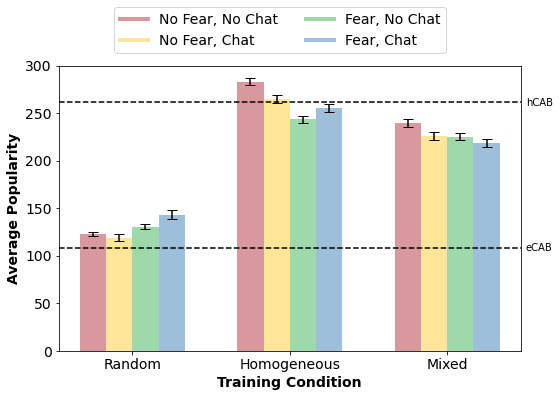

In [ ]:
import seaborn as sns

csvData1 = pd.read_csv("evaluation_summary_1.csv")
csvData2 = pd.read_csv("evaluation_summary_2.csv")
csvData3 = pd.read_csv("evaluation_summary_3.csv")
csvData4 = pd.read_csv("evaluation_summary_4.csv")


combined_data = pd.concat([csvData2, csvData3, csvData1, csvData4], ignore_index=True)

conditions = ["SChMUSR_noFear_noChat", "SChMUSR_noFear_chat", "SChMUSR_fear_noChat", "SChMUSR_fear_chat",
              "SChMUSR_homogeneous_noFear_noChat", "SChMUSR_homogeneous_noFear_chat", "SChMUSR_homogeneous_fear_noChat", "SChMUSR_homogeneous_fear_chat",
              "SChMUSR_mixed_noFear_noChat", "SChMUSR_mixed_noFear_chat", "SChMUSR_mixed_fear_noChat", "SChMUSR_mixed_fear_chat"             
            ]

condition_names = ["No Fear, No Chat", "No Fear, Chat", "Fear, No Chat", "Fear, Chat",
                  "No Fear, No Chat (Homogeneous)", "No Fear, Chat (Homogeneous)", "Fear, No Chat (Homogeneous)", "Fear, Chat (Homogeneous)",
                  "No Fear, No Chat (Mixed)", "No Fear, Chat (Mixed)", "Fear, No Chat (Mixed)", "Fear, Chat (Mixed)"
                  ]

results = pd.DataFrame({
    "Condition": condition_names,
    "SChMUSR Pop": [np.mean(combined_data[f"{condition}_avg_fitness"]) for condition in conditions],
    "CAT Pop": [np.mean(combined_data[f"{condition}_cat_avg_fitness"]) for condition in conditions],
    "hCAB Pop": [np.mean(combined_data[f"{condition}_hCAB_avg_fitness"]) for condition in conditions],
    "Num Runs": [len(combined_data[f"{condition}_count"].dropna()) for condition in conditions],
    "Avg Keep": [np.mean(combined_data[f"{condition}_keep"]) for condition in conditions],
    "Avg Give": [np.mean(combined_data[f"{condition}_give"]) for condition in conditions],
    "Avg Steal": [np.mean(combined_data[f"{condition}_steal"]) for condition in conditions]
})

print(results.to_string(index=False))

titles = ["SChMUSR Popularity"]
metrics = ["avg_fitness"]

plt.rcParams.update({'font.size': 14})  # Adjust the value as needed as needed
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')  # Increased the figure width

labels = ["Random", "Homogeneous", "Mixed"]
x_positions = []
x = 0
width = 0.5
multiplier = 0
for i, metric in enumerate(titles):
    condition_lower_err = []
    condition_upper_err = []
    color_list = []
    condition_type = "Random"

    for condition, condition_name in zip(conditions, condition_names):
        if not combined_data[f"{condition}_{metrics[i]}"].dropna().empty:
            condition_data = combined_data[f"{condition}_{metrics[i]}"].dropna()
            stderr = np.std(condition_data) / np.sqrt(len(condition_data))
            condition_lower_err.append(stderr)
            condition_upper_err.append(stderr)

            offset = width * multiplier

            if condition_type != getConditionType(condition):
                x += 1
                condition_type = getConditionType(condition)

            if condition == "SChMUSR_fear_noChat" or condition == "SChMUSR_homogeneous_fear_noChat" or condition == "SChMUSR_mixed_fear_noChat":

                x_positions.append(x + offset - width/2)

           
            rects = ax.bar(x + offset, np.mean(condition_data), width, color=getColor(condition), label=getConditionType(condition))
            ax.errorbar(x + offset, np.mean(condition_data), yerr=stderr, fmt='none', c='black', capsize=5)
            multiplier += 1

            color = getColor(condition)
            color_list.append(color)

ax.set_xticks(x_positions)
ax.set_xticklabels(labels, ha='center')
ax.set_ylim(0, 300) 
ax.set_ylabel('Average Popularity', fontweight='bold')
ax.set_xlabel('Training Condition', fontweight='bold')

eCAB_pop = 108.324883 
hCAB_pop = 261.186549

ax.axhline(y=eCAB_pop, color='black', linestyle='--', linewidth=1.5, label='eCAB')
ax.text( 8.25, eCAB_pop, 'eCAB', color='black', ha='left', va='center', fontsize=10)

ax.axhline(y=hCAB_pop, color='black', linestyle='--', linewidth=1.5, label='hCAB')
ax.text( 8.25, hCAB_pop, 'hCAB', color='black', ha='left', va='center', fontsize=10)

# Add legend
handles = [
    plt.Line2D([0], [0], color=colors["noFear_noChat"], lw=4, label='No Fear, No Chat'),
    plt.Line2D([0], [0], color=colors["noFear_chat"], lw=4, label='No Fear, Chat'),
    plt.Line2D([0], [0], color=colors["fear_noChat"], lw=4, label='Fear, No Chat'),
    plt.Line2D([0], [0], color=colors["fear_chat"], lw=4, label='Fear, Chat')
]
fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.125))

plt.tight_layout()
plt.show()

fig.savefig("schmusr_selfPlay_popularity_plot.png", dpi=300, bbox_inches='tight')



# Generates SChMUSR popularity for hCAB play only

                     Condition  SChMUSR Pop  CAT Pop   hCAB Pop  Num Runs  Avg Keep  Avg Give  Avg Steal
              No Fear, No Chat   113.880889      NaN 263.101299        20  0.422918  0.535125   0.041957
                 No Fear, Chat   110.968527      NaN 231.919767        11  0.463732  0.489977   0.046291
                 Fear, No Chat   120.043202      NaN 245.839629        18  0.403053  0.549485   0.047461
                    Fear, Chat   135.883680      NaN 210.083583        10  0.418358  0.531357   0.050285
No Fear, No Chat (Homogeneous)   200.277594      NaN 321.019938        14  0.179988  0.772163   0.047849
   No Fear, Chat (Homogeneous)   229.775675      NaN 243.496316        13  0.192844  0.755845   0.049773
   Fear, No Chat (Homogeneous)   184.015290      NaN 285.292388        19  0.211939  0.728899   0.059162
      Fear, Chat (Homogeneous)   226.666039      NaN 221.919507        12  0.210871  0.737007   0.052122
      No Fear, No Chat (Mixed)   174.326007      NaN 30

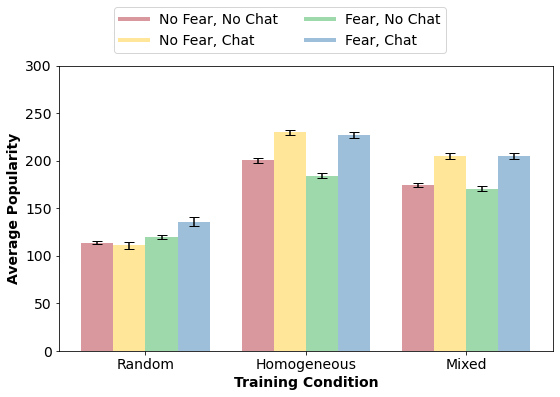

In [ ]:
import seaborn as sns

csvData1 = pd.read_csv("evaluation_summary_1.csv")
csvData2 = pd.read_csv("evaluation_summary_2.csv")
csvData3 = pd.read_csv("evaluation_summary_3.csv")
csvData4 = pd.read_csv("evaluation_summary_4.csv")


combined_data = pd.concat([csvData2, csvData3, csvData1, csvData4], ignore_index=True)

conditions = ["withHCABs_SChMUSR_noFear_noChat", "withHCABs_SChMUSR_noFear_chat", "withHCABs_SChMUSR_fear_noChat", "withHCABs_SChMUSR_fear_chat",
              "withHCABs_SChMUSR_homogeneous_noFear_noChat", "withHCABs_SChMUSR_homogeneous_noFear_chat", "withHCABs_SChMUSR_homogeneous_fear_noChat", "withHCABs_SChMUSR_homogeneous_fear_chat",
              "withHCABs_SChMUSR_mixed_noFear_noChat", "withHCABs_SChMUSR_mixed_noFear_chat", "withHCABs_SChMUSR_mixed_fear_noChat", "withHCABs_SChMUSR_mixed_fear_chat"             
            ]

condition_names = ["No Fear, No Chat", "No Fear, Chat", "Fear, No Chat", "Fear, Chat",
                  "No Fear, No Chat (Homogeneous)", "No Fear, Chat (Homogeneous)", "Fear, No Chat (Homogeneous)", "Fear, Chat (Homogeneous)",
                  "No Fear, No Chat (Mixed)", "No Fear, Chat (Mixed)", "Fear, No Chat (Mixed)", "Fear, Chat (Mixed)"
                  ]

results = pd.DataFrame({
    "Condition": condition_names,
    "SChMUSR Pop": [np.mean(combined_data[f"{condition}_avg_fitness"]) for condition in conditions],
    "CAT Pop": [np.mean(combined_data[f"{condition}_cat_avg_fitness"]) for condition in conditions],
    "hCAB Pop": [np.mean(combined_data[f"{condition}_hCAB_avg_fitness"]) for condition in conditions],
    "Num Runs": [len(combined_data[f"{condition}_count"].dropna()) for condition in conditions],
    "Avg Keep": [np.mean(combined_data[f"{condition}_keep"]) for condition in conditions],
    "Avg Give": [np.mean(combined_data[f"{condition}_give"]) for condition in conditions],
    "Avg Steal": [np.mean(combined_data[f"{condition}_steal"]) for condition in conditions]
})

print(results.to_string(index=False))

titles = ["SChMUSR Popularity"]
metrics = ["avg_fitness"]

plt.rcParams.update({'font.size': 14})  # Adjust the value as needed as needed
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')  # Increased the figure width

labels = ["Random", "Homogeneous", "Mixed"]
x_positions = []
x = 0
width = 0.25
multiplier = 0

for i, metric in enumerate(titles):
    condition_lower_err = []
    condition_upper_err = []
    color_list = []
    condition_type = "Random"

    for condition, condition_name in zip(conditions, condition_names):
        if not combined_data[f"{condition}_{metrics[i]}"].dropna().empty:
            condition_data = combined_data[f"{condition}_{metrics[i]}"].dropna()
            stderr = np.std(condition_data) / np.sqrt(len(condition_data))
            condition_lower_err.append(stderr)
            condition_upper_err.append(stderr)

            offset = width * multiplier

            if condition_type != getConditionType(condition):
                x += .25
                condition_type = getConditionType(condition)

            if condition == "withHCABs_SChMUSR_fear_noChat" or condition == "withHCABs_SChMUSR_homogeneous_fear_noChat" or condition == "withHCABs_SChMUSR_mixed_fear_noChat":

                x_positions.append(x + offset - width/2)

           
            rects = ax.bar(x + offset, np.mean(condition_data), width, color=getColor(condition), label=getConditionType(condition))
            ax.errorbar(x + offset, np.mean(condition_data), yerr=stderr, fmt='none', c='black', capsize=5)
            multiplier += 1

            color = getColor(condition)
            color_list.append(color)

ax.set_xticks(x_positions)
ax.set_xticklabels(labels,  ha='center')
ax.set_ylim(0, 300)
ax.set_ylabel('Average Popularity', fontweight='bold')
ax.set_xlabel('Training Condition', fontweight='bold')

# Add legend
handles = [
    plt.Line2D([0], [0], color=colors["noFear_noChat"], lw=4, label='No Fear, No Chat'),
    plt.Line2D([0], [0], color=colors["noFear_chat"], lw=4, label='No Fear, Chat'),
    plt.Line2D([0], [0], color=colors["fear_noChat"], lw=4, label='Fear, No Chat'),
    plt.Line2D([0], [0], color=colors["fear_chat"], lw=4, label='Fear, Chat')
]
fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.125))

plt.tight_layout()
plt.show()

fig.savefig("schmusr_withHCABs_popularity_plot.png", dpi=300, bbox_inches='tight')


# SChMUSR and hCAB side by side

                     Condition  SChMUSR Pop  CAT Pop   hCAB Pop  Num Runs  Avg Keep  Avg Give  Avg Steal
No Fear, No Chat (Homogeneous)   200.277594      NaN 321.019938        14  0.179988  0.772163   0.047849
   No Fear, Chat (Homogeneous)   229.775675      NaN 243.496316        13  0.192844  0.755845   0.049773
   Fear, No Chat (Homogeneous)   184.015290      NaN 285.292388        19  0.211939  0.728899   0.059162
      Fear, Chat (Homogeneous)   226.666039      NaN 221.919507        12  0.210871  0.737007   0.052122


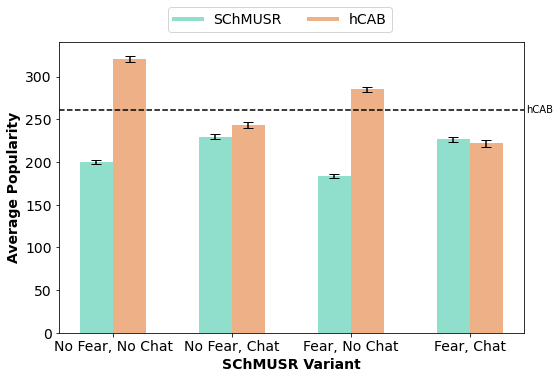

In [ ]:
import seaborn as sns

csvData1 = pd.read_csv("evaluation_summary_1.csv")
csvData2 = pd.read_csv("evaluation_summary_2.csv")
csvData3 = pd.read_csv("evaluation_summary_3.csv")
csvData4 = pd.read_csv("evaluation_summary_4.csv")


combined_data = pd.concat([csvData2, csvData3, csvData1, csvData4], ignore_index=True)

conditions = ["withHCABs_SChMUSR_homogeneous_noFear_noChat", "withHCABs_SChMUSR_homogeneous_noFear_chat", "withHCABs_SChMUSR_homogeneous_fear_noChat", "withHCABs_SChMUSR_homogeneous_fear_chat",
                ]

condition_names = [
                  "No Fear, No Chat (Homogeneous)", "No Fear, Chat (Homogeneous)", "Fear, No Chat (Homogeneous)", "Fear, Chat (Homogeneous)",
                 
                  ]

results = pd.DataFrame({
    "Condition": condition_names,
    "SChMUSR Pop": [np.mean(combined_data[f"{condition}_avg_fitness"]) for condition in conditions],
    "CAT Pop": [np.mean(combined_data[f"{condition}_cat_avg_fitness"]) for condition in conditions],
    "hCAB Pop": [np.mean(combined_data[f"{condition}_hCAB_avg_fitness"]) for condition in conditions],
    "Num Runs": [len(combined_data[f"{condition}_count"].dropna()) for condition in conditions],
    "Avg Keep": [np.mean(combined_data[f"{condition}_keep"]) for condition in conditions],
    "Avg Give": [np.mean(combined_data[f"{condition}_give"]) for condition in conditions],
    "Avg Steal": [np.mean(combined_data[f"{condition}_steal"]) for condition in conditions]
})

print(results.to_string(index=False))

titles = ["SChMUSR Popularity", "hCAB Popularity",]
metrics = ["avg_fitness", "hCAB_avg_fitness"]

plt.rcParams.update({'font.size': 14})  # Adjust the value as needed as needed
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')  # Increased the figure width

labels = ["No Fear, No Chat", "No Fear, Chat", "Fear, No Chat", "Fear, Chat"]
x_positions = []
x = 0
width = 0.25
multiplier = 0

condition_lower_err = []
condition_upper_err = []
color_list = []
condition_type = "Random"

SChMUSR_color = "#90decc"
hCAB_color = "#edb087"

for condition, condition_name in zip(conditions, condition_names):
    SChMUSR_pop = combined_data[f"{condition}_avg_fitness"].dropna()
    hCAB_pop = combined_data[f"{condition}_hCAB_avg_fitness"].dropna()
    
    SChMUSR_err = np.std(SChMUSR_pop) / np.sqrt(len(SChMUSR_pop))
    condition_lower_err.append(SChMUSR_err)
    condition_upper_err.append(SChMUSR_err)

    hCAB_err = np.std(hCAB_pop) / np.sqrt(len(hCAB_pop))
    condition_lower_err.append(hCAB_err)
    condition_upper_err.append(hCAB_err)

    # plot SChMUSR

    offset = width * multiplier

    rects = ax.bar(x + offset, np.mean(SChMUSR_pop), width, color=SChMUSR_color, label = "SChMUSR")
    ax.errorbar(x + offset, np.mean(SChMUSR_pop), yerr=SChMUSR_err, fmt='none', c='black', capsize=5)
    multiplier += 1

    color = SChMUSR_color
    color_list.append(color)

    # plot hcab

    offset = width * multiplier
    x_positions.append(x + offset - width/2)

    rects = ax.bar(x + offset, np.mean(hCAB_pop), width, color=hCAB_color, label = "hCAB")
    ax.errorbar(x + offset, np.mean(hCAB_pop), yerr=hCAB_err, fmt='none', c='black', capsize=5)
    multiplier += 1

    color = hCAB_color
    color_list.append(color)

    x+=.4

ax.set_xticks(x_positions)
ax.set_xticklabels(labels,  ha='center')
ax.set_ylabel('Average Popularity', fontweight='bold')
ax.set_xlabel('SChMUSR Variant', fontweight='bold')



hCAB_pop = 261.186549

ax.axhline(y=hCAB_pop, color='black', linestyle='--', linewidth=1.5, label='hCAB')
ax.text( 3.25, hCAB_pop, 'hCAB', color='black', ha='left', va='center', fontsize=10)

# Add legend
handles = [
    plt.Line2D([0], [0], color=SChMUSR_color, lw=4, label='SChMUSR'),
    plt.Line2D([0], [0], color=hCAB_color, lw=4, label='hCAB'),   
    ]
   
fig.legend(handles=handles, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.075))

plt.tight_layout()
plt.show()

fig.savefig("schmusr_withHCABs_homogeneous.png", dpi=300, bbox_inches='tight')


# ANOVA 

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd

csvData1 = pd.read_csv("evaluation_summary_1.csv")
csvData2 = pd.read_csv("evaluation_summary_2.csv")
csvData3 = pd.read_csv("evaluation_summary_3.csv")
csvData4 = pd.read_csv("evaluation_summary_4.csv")

combined_data = pd.concat([csvData2, csvData3, csvData1, csvData4], ignore_index=True)


conditions = ["SChMUSR_noFear_noChat", "SChMUSR_noFear_chat", "SChMUSR_fear_noChat", "SChMUSR_fear_chat",
              "SChMUSR_homogeneous_noFear_noChat", "SChMUSR_homogeneous_noFear_chat", "SChMUSR_homogeneous_fear_noChat", "SChMUSR_homogeneous_fear_chat",
              "SChMUSR_mixed_noFear_noChat", "SChMUSR_mixed_noFear_chat", "SChMUSR_mixed_fear_noChat", "SChMUSR_mixed_fear_chat",
              "withCats_SChMUSR_noFear_noChat", "withCats_SChMUSR_noFear_chat", "withCats_SChMUSR_fear_noChat", "withCats_SChMUSR_fear_chat",
              "withCats_SChMUSR_homogeneous_noFear_noChat", "withCats_SChMUSR_homogeneous_noFear_chat", "withCats_SChMUSR_homogeneous_fear_noChat", "withCats_SChMUSR_homogeneous_fear_chat",
              "withCats_SChMUSR_mixed_noFear_noChat", "withCats_SChMUSR_mixed_noFear_chat", "withCats_SChMUSR_mixed_fear_noChat", "withCats_SChMUSR_mixed_fear_chat",              
              "withHCABs_SChMUSR_noFear_noChat", "withHCABs_SChMUSR_noFear_chat", "withHCABs_SChMUSR_fear_noChat", "withHCABs_SChMUSR_fear_chat",
              "withHCABs_SChMUSR_homogeneous_noFear_noChat", "withHCABs_SChMUSR_homogeneous_noFear_chat", "withHCABs_SChMUSR_homogeneous_fear_noChat", "withHCABs_SChMUSR_homogeneous_fear_chat",
              "withHCABs_SChMUSR_mixed_noFear_noChat", "withHCABs_SChMUSR_mixed_noFear_chat", "withHCABs_SChMUSR_mixed_fear_noChat", "withHCABs_SChMUSR_mixed_fear_chat", 
            ]

def getTraining(condition_names):
    for condition in condition_names:
        if "homogeneous" in condition.lower():
            return "homogeneous"
        elif "mixed" in condition.lower():
            return "mixed"
        else:
            return "random"
    return training

results = pd.DataFrame(columns=["pop", "chat", "fear", "training"])
resultsWithCats = pd.DataFrame(columns=["pop", "chat", "fear", "training"])
resultsWithHCabs = pd.DataFrame(columns=["pop", "chat", "fear", "training"])

for condition in conditions:
        for row in combined_data[f"{condition}_avg_fitness"]:
            if not np.isnan(row):
                chat = 0 if "nochat" in condition.lower() else 1
                fear = 0 if "nofear" in condition.lower() else 1
                training = getTraining([condition])
                if "withCats" in condition:
                    resultsWithCats = pd.concat([resultsWithCats, pd.DataFrame([{"pop": row, "chat": chat, "fear": fear, "training": training}])], ignore_index=True)
                elif "withHCABs" in condition:
                    resultsWithHCabs = pd.concat([resultsWithHCabs, pd.DataFrame([{"pop": row, "chat": chat, "fear": fear, "training": training}])], ignore_index=True)
                else:
                    results = pd.concat([results, pd.DataFrame([{"pop": row, "chat": chat, "fear": fear, "training": training}])], ignore_index=True)
            
results['pop'] = pd.to_numeric(results['pop'])
resultsWithCats['pop'] = pd.to_numeric(resultsWithCats['pop'])
resultsWithHCabs['pop'] = pd.to_numeric(resultsWithHCabs['pop'])

model = ols("""pop ~ C(chat) + C(fear) + C(training) +
               C(chat):C(fear) + C(chat):C(training) + C(fear):C(training) +
               C(chat):C(fear):C(training)""", data=results).fit()

print("Self Play")
anova_self_play = sm.stats.anova_lm(model, typ=2)
print(anova_self_play)

modelWithCats = ols("""pop ~ C(chat) + C(fear) + C(training) +
               C(chat):C(fear) + C(chat):C(training) + C(fear):C(training) +
               C(chat):C(fear):C(training)""", data=resultsWithCats).fit()

anova_with_cats = sm.stats.anova_lm(modelWithCats, typ=2)
print("\n\nWith Cats")
print(anova_with_cats)

modelWithHCabs = ols("""pop ~ C(chat) + C(fear) + C(training) +
                C(chat):C(fear) + C(chat):C(training) + C(fear):C(training) +
                C(chat):C(fear):C(training)""", data=resultsWithHCabs).fit()

anova_with_hcabs = sm.stats.anova_lm(modelWithHCabs, typ=2)
print("\n\nWith HCABs")
print(anova_with_hcabs)

for column in ["chat", "fear", "training"]:
    tukey = pairwise_tukeyhsd(endog=results['pop'],
                            groups=results[column],
                            alpha=0.05)
    print(f"\n\nSelf Play {column}")
    print(tukey)


for column in ["chat", "fear", "training"]:
    tukey = pairwise_tukeyhsd(endog=resultsWithCats['pop'],
                            groups=resultsWithCats[column],
                            alpha=0.05)
    print(f"\n\nWith Cats {column}")
    print(tukey)

for column in ["chat", "fear", "training"]:
    tukey = pairwise_tukeyhsd(endog=resultsWithHCabs['pop'],
                            groups=resultsWithHCabs[column],
                            alpha=0.05)
    print(f"\n\nWith HCABs {column}")
    print(tukey)



Self Play
                                   sum_sq      df            F        PR(>F)
C(chat)                      1.161172e+04     1.0     2.316204  1.281033e-01
C(fear)                      6.935120e+04     1.0    13.833573  2.022028e-04
C(training)                  1.404733e+07     2.0  1401.019204  0.000000e+00
C(chat):C(fear)              8.059088e+04     1.0    16.075565  6.186412e-05
C(chat):C(training)          3.842329e+04     2.0     3.832171  2.173425e-02
C(fear):C(training)          3.208788e+05     2.0    32.003052  1.586805e-14
C(chat):C(fear):C(training)  2.299460e+04     2.0     2.293381  1.010443e-01
Residual                     2.224882e+07  4438.0          NaN           NaN


With Cats
                                   sum_sq      df            F        PR(>F)
C(chat)                      4.899620e+05     1.0   228.197171  2.703607e-50
C(fear)                      7.438181e+02     1.0     0.346429  5.561719e-01
C(training)                  4.821329e+06     2.0  112